# PyTorch Fundamentals

This notebook covers the fundamentals of working with PyTorch for deep learning, including:
- Loading data from Hugging Face
- Applying proper transformations and normalization
- Using pre-trained models (ResNet50)
- Setting up training with appropriate optimization parameters

## Setting Up the Environment

In [40]:
# Check for or install all necessary packages with conda from environment.yml
# %conda env update -f ../environment.yml

# For colab
# !pip install datasets

In [8]:
# Import necessary libraries
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from huggingface_hub import login
from huggingface_hub import hf_hub_download
from datasets import load_dataset, Features, Value
from torchvision import transforms, models
from torchvision.models import ResNet50_Weights
import matplotlib.pyplot as plt
import numpy as np
import base64
import io
from PIL import Image
from io import BytesIO
# Import F1 score calculation
from sklearn.metrics import f1_score

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [ ]:
# Login to Hugging Face with token if necessary
# login()

## Data Loading from Hugging Face

In [11]:
train_dataset = load_dataset("mpg-ranch/horse-detection", split="train")
test_dataset = load_dataset("mpg-ranch/horse-detection", split="test")

Presence: 1 (1=horse present, 0=absent)
Image size: (390, 390)


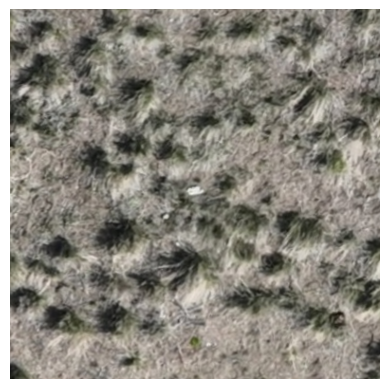

In [16]:
# Access an example
example = next(iter(train_dataset))

image = Image.open(BytesIO(example["image"]))

print(f"Presence: {example['Presence']} (1=horse present, 0=absent)")
print(f"Image size: {image.size}")

plt.imshow(image)
plt.axis('off')
plt.show()

## Creating Data Transformations

Data normalization is **critical** for model performance. We use ImageNet statistics for normalization since we'll be using a pre-trained model.

In [ ]:
# Get the preprocessing transforms directly from the weights
weights = ResNet50_Weights.IMAGENET1K_V1
val_transforms = weights.transforms()

# Define transformations for training data (augmentations + the model's preprocessing)
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# Print available metadata keys
print("Available metadata keys:")
if hasattr(weights, 'meta'):
    print(list(weights.meta.keys()))
else:
    print("No 'meta' attribute found")

# Print the preprocessing information safely
print("\nModel expects the following preprocessing:")
try:
    # Try different possible key names for input size
    if hasattr(weights, 'meta'):
        if 'input_size' in weights.meta:
            print(f"- Input size: {weights.meta['input_size']}")
        elif 'imageSize' in weights.meta:
            print(f"- Input size: {weights.meta['imageSize']}")
        else:
            print("- Input size: Not found in metadata")
            
        # Try different possible key names for mean/std
        if 'mean' in weights.meta:
            print(f"- Mean: {weights.meta['mean']}")
        else:
            print("- Mean: [0.485, 0.456, 0.406] (ImageNet standard)")
            
        if 'std' in weights.meta:
            print(f"- Std: {weights.meta['std']}")
        else:
            print("- Std: [0.229, 0.224, 0.225] (ImageNet standard)")
    else:
        print("Metadata not available, using standard ImageNet values:")
        print("- Input size: [3, 224, 224]")
        print("- Mean: [0.485, 0.456, 0.406]")
        print("- Std: [0.229, 0.224, 0.225]")
except Exception as e:
    print(f"Error accessing metadata: {e}")
    print("Using standard ImageNet values:")
    print("- Input size: [3, 224, 224]")
    print("- Mean: [0.485, 0.456, 0.406]")
    print("- Std: [0.229, 0.224, 0.225]")

# Print information about the transforms
print("\nTransforms from weights:")
print(val_transforms)

# Validation transformations (no augmentation, only resize and normalize)
val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

## Applying Transformations to Dataset

In [64]:
# Function to apply transformations to the training dataset
def transform_train_dataset(examples):
    examples["pixel_values"] = [
        train_transforms(Image.open(BytesIO(image)).convert("RGB")) 
        for image in examples["image"]
    ]
    return examples

# Function to apply transformations to the validation dataset
def transform_val_dataset(examples):
    examples["pixel_values"] = [
        val_transforms(Image.open(BytesIO(image)).convert("RGB")) 
        for image in examples["image"]
    ]
    return examples

# Apply transformations to training set
transformed_train_dataset = train_dataset.map(
    transform_train_dataset,
    batched=True,
    remove_columns=["image"]  # Remove original images after transformation
)

# Apply transformations to test set
transformed_val_dataset = test_dataset.map(
    transform_val_dataset,
    batched=True,
    remove_columns=["image"]
)

# Set the format for PyTorch
transformed_train_dataset.set_format(type="torch", columns=["pixel_values", "Presence"])
transformed_val_dataset.set_format(type="torch", columns=["pixel_values", "Presence"])

## Creating DataLoaders

In [65]:
# Create DataLoaders
train_dataloader = DataLoader(
    transformed_train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=4
)

val_dataloader = DataLoader(
    transformed_val_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=4
)

## Visualizing a Batch

Let's visualize some images from our dataloader to verify transformations are applied correctly.

In [ ]:
# Function to denormalize images for visualization
def denormalize(tensor):
    # Make sure tensor is the right shape and type
    if tensor.ndim != 3:  # If not a single image with 3 dimensions (C,H,W)
        if tensor.ndim == 4:  # If it's a batch of images (B,C,H,W)
            tensor = tensor[0]  # Take the first image
        else:
            raise ValueError(f"Unexpected tensor shape: {tensor.shape}")
    
    # Make sure we're working with the image tensor, not other data
    if tensor.shape[0] == 3:  # If first dimension is 3, it's likely the channel dimension
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        return tensor * std + mean
    else:
        raise ValueError(f"Expected 3 channels, got {tensor.shape[0]}")

# Get a batch from the dataloader
batch = next(iter(train_dataloader))

# Check the structure of the batch
print(f"Batch type: {type(batch)}")
if isinstance(batch, dict):
    print(f"Batch keys: {batch.keys()}")
    images = batch['pixel_values']  # Adjust based on your actual key
    Presences = batch['Presence']  # Adjust based on your actual key
else:
    # If it's a tuple or list, unpack accordingly
    images, Presences = batch

print(f"Images shape: {images.shape}")
print(f"Presences shape: {Presences.shape}")

# Visualize a few images from the batch
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
axes = axes.flatten()

for i, ax in enumerate(axes):
    if i < len(images):
        # Denormalize the image
        img = denormalize(images[i])
        img = img.permute(1, 2, 0).numpy()  # Change from CxHxW to HxWxC
        img = np.clip(img, 0, 1)  # Clip values to valid range
        
        ax.imshow(img)
        ax.set_title(f"Presence: {Presences[i].item()}")
        ax.axis("off")

plt.tight_layout()
plt.show()

## Model Architecture with ResNet50

In [ ]:
# Load pre-trained ResNet50
model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Modify the final fully connected layer for our task
# For CIFAR-10, we have 10 classes
num_classes = 10
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Print model architecture summary
print(f"Model: ResNet50")
print(f"Number of trainable parameters: {sum(p.numel() for p in model.fc.parameters() if p.requires_grad)}")

## Training Configuration

We'll use default settings for the optimizer and only tune the learning rate and number of epochs.

In [68]:
# Modify the final fully connected layer for binary classification
model.fc = nn.Linear(model.fc.in_features, 1)  # Output a single value

# Unfreeze the last convolutional block (layer4) of ResNet50
for param in model.parameters():
    param.requires_grad = False  # First freeze everything
    
# Then unfreeze the final block
for param in model.layer4.parameters():
    param.requires_grad = True
    
# Also keep the FC layer trainable
for param in model.fc.parameters():
    param.requires_grad = True

# Define loss function for binary classification
criterion = nn.BCEWithLogitsLoss()

# Use a smaller learning rate for fine-tuning
learning_rate = 0.0001  # Reduced from 0.001
optimizer = optim.Adam([
    {'params': model.layer4.parameters(), 'lr': learning_rate/10},  # Smaller LR for pretrained layers
    {'params': model.fc.parameters(), 'lr': learning_rate}          # Original LR for new layers
])

# Print trainable parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {trainable_params:,}")

# Number of epochs is another parameter we'll tune
num_epochs = 20  # Keep at 20 since we're doing more complex training

## Training Loop

In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model = model.to(device)

# Lists to store metrics for plotting
train_losses = []
train_accs = []
train_f1s = []  # New list for training F1 scores
val_losses = []
val_accs = []
val_f1s = []    # New list for validation F1 scores

# Check the structure of a batch to understand the data format
sample_batch = next(iter(train_dataloader))
print(f"Batch type: {type(sample_batch)}")
if isinstance(sample_batch, dict):
    print(f"Batch keys: {sample_batch.keys()}")
    # Adjust these based on your actual keys
    image_key = 'pixel_values' if 'pixel_values' in sample_batch else 'img'
    Presence_key = 'Presence' if 'Presence' in sample_batch else 'Presences'
    print(f"Using keys - Images: '{image_key}', Presences: '{Presence_key}'")
else:
    print(f"Batch is a {type(sample_batch)} with {len(sample_batch)} elements")
    for i, item in enumerate(sample_batch):
        print(f"  Item {i} type: {type(item)}")

# Training loop
for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    all_train_preds = []  # To store all training predictions
    all_train_labels = [] # To store all training labels

    for batch in train_dataloader:
        # Extract images and Presences based on the batch structure
        if isinstance(batch, dict):
            # Dictionary format (common with Hugging Face datasets)
            images = batch['pixel_values'] if 'pixel_values' in batch else batch['img']
            Presences = batch['Presence'] if 'Presence' in batch else batch['Presences']
        else:
            # Tuple/list format (common with PyTorch datasets)
            images, Presences = batch

        # Move data to device
        images, Presences = images.to(device), Presences.to(device)

        # Convert Presences to float for BCEWithLogitsLoss
        Presences = Presences.float()

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        outputs = outputs.squeeze(1)  # Change from [batch_size, 1] to [batch_size]
        loss = criterion(outputs, Presences)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item()

        # For binary classification with BCEWithLogitsLoss
        predicted = (torch.sigmoid(outputs) > 0.5).float()
        total += Presences.size(0)
        correct += predicted.eq(Presences).sum().item()

        # Collect predictions and labels for F1 calculation
        all_train_preds.extend(predicted.cpu().numpy())
        all_train_labels.extend(Presences.cpu().numpy())

    # Calculate training metrics
    train_loss = running_loss / len(train_dataloader)
    train_acc = 100. * correct / total
    train_f1 = f1_score(all_train_labels, all_train_preds, average='binary')

    # Store metrics
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    train_f1s.append(train_f1)

    # Validation phase
    model.eval()
    val_running_loss = 0.0
    correct = 0
    total = 0
    all_val_preds = []    # To store all validation predictions
    all_val_labels = []   # To store all validation labels

    with torch.no_grad():
        for batch in val_dataloader:
            # Extract images and Presences based on the batch structure
            if isinstance(batch, dict):
                # Dictionary format (common with Hugging Face datasets)
                images = batch['pixel_values'] if 'pixel_values' in batch else batch['img']
                Presences = batch['Presence'] if 'Presence' in batch else batch['Presences']
            else:
                # Tuple/list format (common with PyTorch datasets)
                images, Presences = batch

            # Move data to device
            images, Presences = images.to(device), Presences.to(device)

            # Convert Presences to float for BCEWithLogitsLoss
            Presences = Presences.float()

            outputs = model(images)
            outputs = outputs.squeeze(1)  # Change from [batch_size, 1] to [batch_size]
            loss = criterion(outputs, Presences)

            val_running_loss += loss.item()

            # For binary classification with BCEWithLogitsLoss
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            total += Presences.size(0)
            correct += predicted.eq(Presences).sum().item()

            # Collect predictions and labels for F1 calculation
            all_val_preds.extend(predicted.cpu().numpy())
            all_val_labels.extend(Presences.cpu().numpy())

    # Calculate validation metrics
    val_loss = val_running_loss / len(val_dataloader)
    val_acc = 100. * correct / total
    val_f1 = f1_score(all_val_labels, all_val_preds, average='binary')

    # Store metrics
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    val_f1s.append(val_f1)

    # Print epoch results including F1 scores
    print(f'Epoch: {epoch+1}/{num_epochs}, '
          f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Train F1: {train_f1:.4f}, '
          f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%, Val F1: {val_f1:.4f}')

## Visualizing Training Progress

In [ ]:
# Plot training and validation metrics
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot loss
ax1.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
ax1.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True)

# Plot accuracy
ax2.plot(range(1, num_epochs+1), train_accs, label='Train Accuracy')
ax2.plot(range(1, num_epochs+1), val_accs, label='Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

## Key Points to Remember

1. **Data Normalization is Critical**
   - Always normalize your input data using mean and standard deviation
   - For transfer learning with pre-trained models, use the same normalization values that were used during pre-training (e.g., ImageNet stats)

2. **Data Transformations**
   - Apply appropriate augmentations for training data (flips, rotations, crops)
   - Use only resizing and normalization for validation/test data
   - Transformations help prevent overfitting and improve model generalization

3. **Model Architecture**
   - Start with a pre-trained model like ResNet50
   - Modify only the final layer (head) to match your specific task
   - Freeze pre-trained layers initially to leverage transfer learning

4. **Optimization Settings**
   - Start with default optimizer settings
   - Focus on tuning learning rate and number of epochs first
   - Monitor validation metrics to prevent overfitting

5. **Progressive Unfreezing**
   - After initial training, you can unfreeze more layers gradually
   - Use a smaller learning rate when fine-tuning pre-trained layers

## Next Steps

1. **Hyperparameter Tuning**
   - Try different learning rates
   - Experiment with different batch sizes
   - Test different optimizers (SGD with momentum, AdamW)

2. **Model Improvements**
   - Unfreeze more layers for fine-tuning
   - Try different pre-trained architectures (EfficientNet, ViT)
   - Implement learning rate scheduling

3. **Advanced Techniques**
   - Implement data augmentation strategies like mixup or cutmix
   - Try different loss functions
   - Implement ensemble methods